## Accessing Sentinel-1 GRD data on Azure

The [Sentinel-1](https://sentinel.esa.int/web/sentinel/missions/sentinel-1) program provides global synthetic aperature radar imaging with a revisit time of approximately six days.  The [Ground Range Detected](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/ground-range-detected) (GRD) product has been detected and projected to ground range.  This dataset represents the global Sentinel-1 GRD archive, from 2017 to the present, converted to [cloud-optimized GeoTIFF](https://www.cogeo.org/) format.

This notebook demonstrates basic access to Sentinel-1 GRD data on Azure, using sentinelsat to query the Copernicus Open Access Hub for tiles, then accessing the tiles on Azure blob storage.  Because Sentinel-1 data are in preview, the user needs to provide storage credentials.  To access the Copernicus Open Access Hub for spatiotemporal search, the user also needs to provide Open Access Hub credentials.

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented at [aka.ms/ai4edata-sentinel-1](http://aka.ms/ai4edata-sentinel-1).

Sentinel-1 data on Azure are maintained by [Sinergise](https://sinergise.com/).

### Environment setup

In [3]:
import os
import datetime
import json
import requests
import numpy as np
import matplotlib.pyplot as plt

import rasterio

!pip install sentinelsat
!pip install azure-storage-blob

from sentinelsat import SentinelAPI, geojson_to_wkt
from azure.storage.blob import ContainerClient

### Auth files

In [5]:
print(os.getcwd())

/home/jovyan/PlanetaryComputerExamples


In [9]:
# This can be either a SAS token or a file with a SAS token on the file line
sas_token = '?sv=2020-04-08&si=s1-grd-ro-tmp&sr=c&sig=sHcBs2%2BCmTKurz73FRSDK2keoRKWbxsYhssLjVy%2BsTQ%3D'

# A text file with a login on the first line, password on the second line... basically 
# an even-less-fancy .netrc
copernicus_credentials_file = None

# Or specify username/password
username = ''; password = ''

### Constants

In [7]:
api_url = 'https://scihub.copernicus.eu/dhus'
platform_name = 'Sentinel-1'

# Query parameters
start_time = datetime.datetime(2021,1,1,0,0,0)
end_time = datetime.datetime(2021,2,1,0,0,0)

# URL containing a geojson file with an area of interest, in this case a rectangle around Seattle
query_geojson_url = 'https://ai4edatasetspublicassets.blob.core.windows.net/assets/stuff-near-seattle.geojson'

# Scaling constants that control rendering brightness
norm_value = 1500
composite_norm_value = 500

# When rendering whole images, how much should we downscale?
dsfactor = 10

### Create container client

In [8]:
if os.path.isfile(sas_token):
    lines = []
    with open(sas_token,'r') as f:
        lines = f.readlines()
    assert len(lines) >= 1
    sas_token = lines[0].strip()
    
storage_account_name = 'sentinel1euwest'
container_name = 's1-grd'

storage_account_url = 'https://' + storage_account_name + '.blob.core.windows.net/'

container_client = ContainerClient(account_url=storage_account_url, 
                                             container_name=container_name,
                                             credential=sas_token)

### Load username/pw for Open Access Hub

In [10]:
if copernicus_credentials_file is not None:

    assert username is None 
    assert password is None    

    lines = []
    with open(copernicus_credentials_file,'r') as f:
        lines = f.readlines()
    assert len(lines) >= 2
    
    username = lines[0].strip()
    password = lines[1].strip()

### Connect to the hub API

In [11]:
api = SentinelAPI(user=username, password=password, api_url=api_url)

### Query for tiles

In [12]:
geojson = json.loads(requests.get(query_geojson_url).text)
footprint = geojson_to_wkt(geojson)

products = api.query(footprint,
                     producttype='GRD',
                     date=(start_time,end_time),
                     platformname=platform_name)

### List products

In [13]:
product_values = list(products.values())
    
print('Found {} tiles:'.format(len(products)))
for p in product_values:
    print(p['filename'])

Found 16 tiles:
S1B_IW_GRDH_1SDV_20210129T020125_20210129T020150_025363_030553_F429.SAFE
S1B_IW_GRDH_1SDV_20210129T020150_20210129T020215_025363_030553_48CA.SAFE
S1B_IW_GRDH_1SDV_20210127T141257_20210127T141327_025341_0304A3_6E12.SAFE
S1B_IW_GRDH_1SDV_20210127T141232_20210127T141257_025341_0304A3_F6D6.SAFE
S1B_IW_GRDH_1SDV_20210124T015328_20210124T015353_025290_0302FD_BD63.SAFE
S1B_IW_GRDH_1SDV_20210120T142048_20210120T142113_025239_030157_02F1.SAFE
S1B_IW_GRDH_1SDV_20210117T020150_20210117T020215_025188_02FFBE_972E.SAFE
S1B_IW_GRDH_1SDV_20210117T020125_20210117T020150_025188_02FFBE_3068.SAFE
S1B_IW_GRDH_1SDV_20210115T141257_20210115T141327_025166_02FF0F_810D.SAFE
S1B_IW_GRDH_1SDV_20210115T141232_20210115T141257_025166_02FF0F_1170.SAFE
S1B_IW_GRDH_1SDV_20210112T015328_20210112T015353_025115_02FD69_43DB.SAFE
S1B_IW_GRDH_1SDV_20210108T142048_20210108T142113_025064_02FBBD_C037.SAFE
S1B_IW_GRDH_1SDV_20210105T020126_20210105T020151_025013_02FA23_7F71.SAFE
S1B_IW_GRDH_1SDV_20210105T020151_20

### Grab the first product

In [14]:
product = product_values[0]

In [15]:
import pprint; pp = pprint.PrettyPrinter(indent=2)
pp.pprint(product)

{ 'acquisitiontype': 'NOMINAL',
  'beginposition': datetime.datetime(2021, 1, 29, 2, 1, 25, 407000),
  'endposition': datetime.datetime(2021, 1, 29, 2, 1, 50, 407000),
  'filename': 'S1B_IW_GRDH_1SDV_20210129T020125_20210129T020150_025363_030553_F429.SAFE',
  'footprint': 'MULTIPOLYGON (((-123.969368 45.992237, -120.676697 46.3904, '
               '-121.011612 47.888786, -124.397346 47.490295, -123.969368 '
               '45.992237)))',
  'format': 'SAFE',
  'gmlfootprint': '<gml:Polygon '
                  'srsName="http://www.opengis.net/gml/srs/epsg.xml#4326" '
                  'xmlns:gml="http://www.opengis.net/gml">\n'
                  '   <gml:outerBoundaryIs>\n'
                  '      <gml:LinearRing>\n'
                  '         <gml:coordinates>47.490295,-124.397346 '
                  '47.888786,-121.011612 46.390400,-120.676697 '
                  '45.992237,-123.969368 '
                  '47.490295,-124.397346</gml:coordinates>\n'
                  '      </gml:Lin

### Formulate a Sentinel-1 path in our container's format

In [16]:
# For the product:
#
# S1B_IW_GRDH_1SDV_20210129T020125_20210129T020150_025363_030553_F429.SAFE
#    
# Our path is:
#    
# https://sentinel1euwest.blob.core.windows.net/s1-grd/
#
# GRD/2021/1/29/IW/DV/S1B_IW_GRDH_1SDV_20210129T020125_20210129T020150_025363_030553_F429/
#
# Everything here can be pulled directly from the scene name, we don't actually need the product
# metadata.

root = 'GRD'

scene_name = product['filename'].replace('.SAFE','')
mode = scene_name[4:6]
polarization = scene_name[14:16] # "DV", for example, is "dual VV/VH"
year = scene_name[17:21];
month = scene_name[21:23].lstrip('0');
day = scene_name[23:25].lstrip('0');

azure_scene_prefix = '/'.join([root,year,month,day,mode,polarization,scene_name])

print('Azure scene prefix: {}'.format(azure_scene_prefix))

Azure scene prefix: GRD/2021/1/29/IW/DV/S1B_IW_GRDH_1SDV_20210129T020125_20210129T020150_025363_030553_F429


### List matching blobs

In [17]:
generator = container_client.list_blobs(name_starts_with=azure_scene_prefix)
scene_files = list(generator)
image_blobs = [blob.name for blob in scene_files if blob.name.endswith('.tiff')]
preview_blobs = [blob.name for blob in scene_files if blob.name.endswith('quick-look.png')]

print('Found {} image files and {} preview files:'.format(len(image_blobs),len(preview_blobs)))
for s in image_blobs:
    print(s)
for s in preview_blobs:
    print(s)    

Found 2 image files and 1 preview files:
GRD/2021/1/29/IW/DV/S1B_IW_GRDH_1SDV_20210129T020125_20210129T020150_025363_030553_F429/measurement/iw-vh.tiff
GRD/2021/1/29/IW/DV/S1B_IW_GRDH_1SDV_20210129T020125_20210129T020150_025363_030553_F429/measurement/iw-vv.tiff
GRD/2021/1/29/IW/DV/S1B_IW_GRDH_1SDV_20210129T020125_20210129T020150_025363_030553_F429/preview/quick-look.png


### Convert to Azure blob URLs

In [18]:
image_urls = []
for blob_path in image_blobs:
    image_urls.append(storage_account_url + container_name + '/' + blob_path + sas_token)
preview_urls = []
for blob_path in preview_blobs:
    preview_urls.append(storage_account_url + container_name + '/' + blob_path + sas_token)

### Render the original thumbnail image

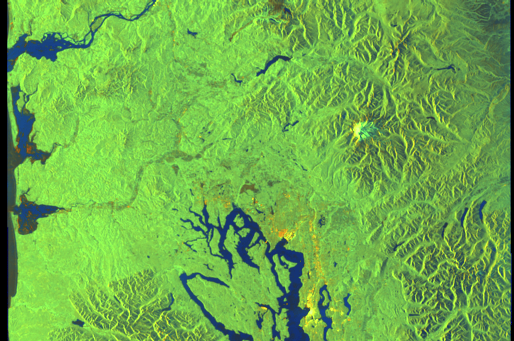

In [19]:
from PIL import Image
from IPython.display import display
import requests
import io

url = preview_urls[0]
response = requests.get(url)
image_bytes = io.BytesIO(response.content)
img = Image.open(image_bytes)
display(img)

### Render previews from COG files without reading the whole file

We'll render our two images (two capture modes) separately.

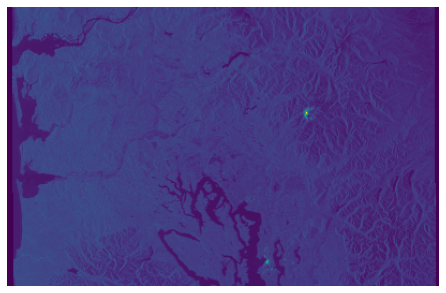

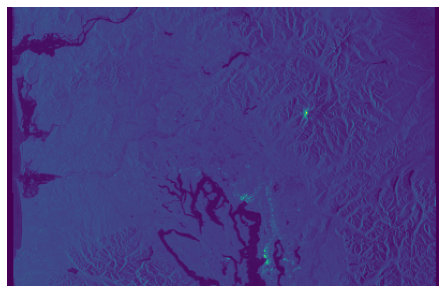

In [20]:
for url in image_urls:
    
    with rasterio.open(url) as raster:
        
        # List of overviews from biggest to smallest
        oviews = raster.overviews(1)
    
        # Retrieve the smallest thumbnail
        decimation_level = oviews[-1]
        h = int(raster.height/decimation_level)
        w = int(raster.width/decimation_level)
        
        d = raster.read(1, out_shape=(1, h, w)) / norm_value
        np.clip(d,0,1,d)
        fig = plt.figure(frameon=False); ax = plt.Axes(fig,[0., 0., 1., 1.]); ax.set_axis_off(); fig.add_axes(ax)
        plt.imshow(d)


### Composite the captures into one image for the scene

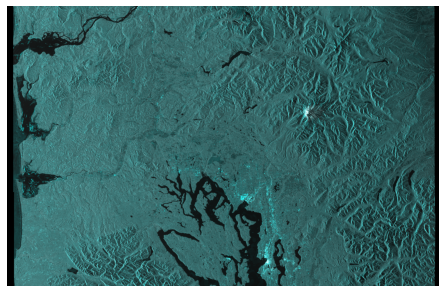

In [22]:
image_data = []

for url in image_urls:
    with rasterio.open(url,'r') as raster:
        h = int(raster.height/dsfactor)
        w = int(raster.width/dsfactor)
        band_array = raster.read(1, out_shape=(1, h, w))
        raster.close()
        band_array = band_array / composite_norm_value
        image_data.append(band_array)

# Lazily re-use the last capture to make an RGB image        
while len(image_data) < 3:
    image_data.append(image_data[-1])
rgb = np.dstack((image_data[0],image_data[1],image_data[2]))

np.clip(rgb,0,1,rgb)
fig = plt.figure(frameon=False); ax = plt.Axes(fig,[0., 0., 1., 1.]); ax.set_axis_off(); fig.add_axes(ax)                
plt.imshow(rgb);